# Main code was done in colab, so there might not be fresh code

# **Установка библиотеки Ultralytics, которая предоставляет нам модельку YOLO**

In [2]:
!pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.66 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


# **We will use VehicleDetectionDataset, that we have in our google drive.**
P.S. It will be in our github repository root

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


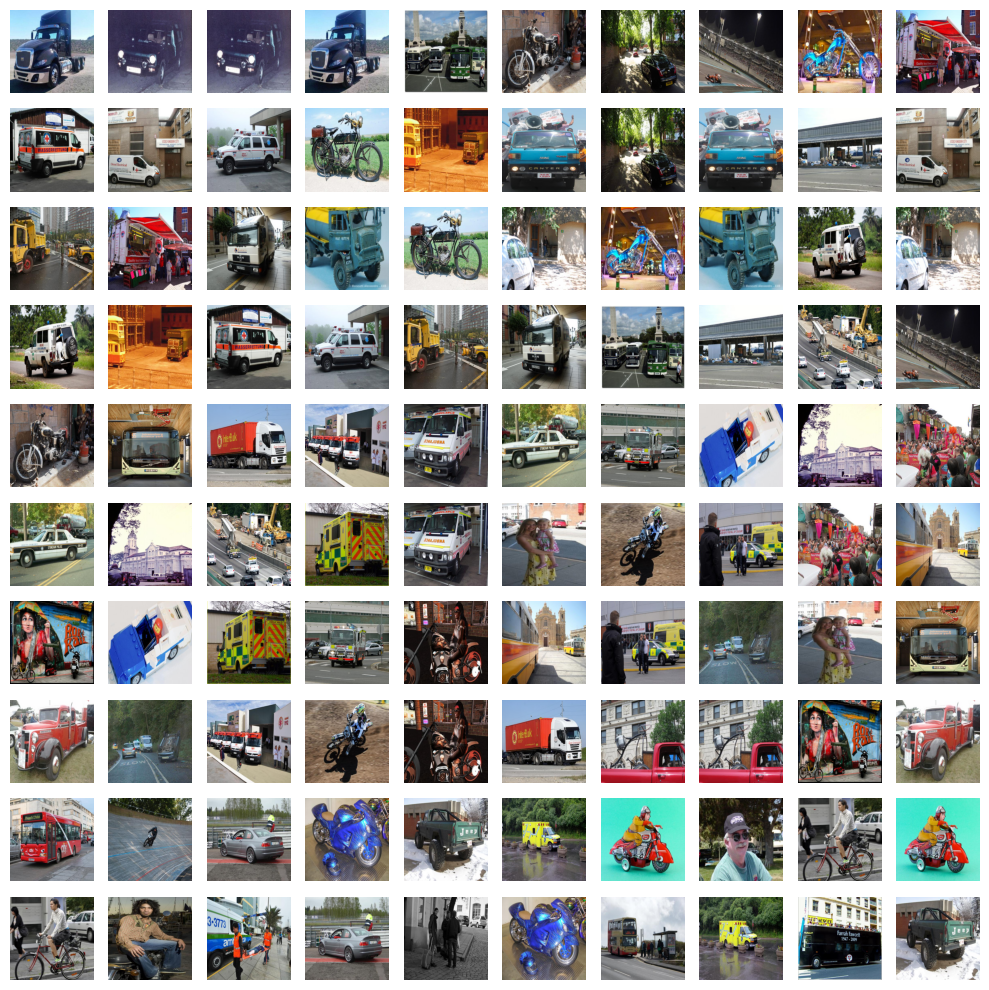

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

folder_path = "/content/drive/MyDrive/VehiclesDetectionDataset/train/images"

image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_rows = 10
num_cols = 10


fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j

        if idx < len(image_files):
            image_path = image_files[idx]
            image = Image.open(image_path)

            axes[i, j].imshow(image)
            axes[i, j].axis('off')
        else:
            break

plt.tight_layout()
plt.show()

## **We will copy the dataset to our root directory, in order to not accidentally change original dataset.**

In [ ]:
from ultralytics import YOLO
from glob import glob
import os

def make_ds(root, path_to_copy):
    os.makedirs(path_to_copy, exist_ok = True)
    files = glob(f"{root}/*")
    for idx, file in enumerate(files):
        if os.path.isdir(file): os.system(f"cp -r {file} {path_to_copy}")
        elif os.path.isfile(file): os.system(f"cp {file} {path_to_copy}")

root = "/content/drive/MyDrive/VehiclesDetectionDataset"
make_ds(root = root, path_to_copy = "/content/datasets")

### **Train YOLO Model**

In [ ]:
!yolo task=detect mode=train model=yolov8x.pt data="/content/datasets/dataset.yaml" epochs=30 lr0=0.001 imgsz=640 plots=True

# **Set prediction mode and visualise the video or images**

In [ ]:
!yolo task=detect mode=predict model="/content/runs/detect/train/weights/best.pt" conf = 0.5 source = "/content/datasets/test/images" save = True

2024-05-08 20:46:21.785610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 20:46:21.785673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 20:46:21.786951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 20:46:23.090585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.66 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68128383 parameters, 0 gradients, 257.4 GFLOPs

image 1/126 /content/datasets/test/images/00dea1edf14f09ab_jpg.rf.3f17c


### **Display them**

In [ ]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

for image_path in glob(f'/content/runs/detect/predict/*.jpg')[5:15]:
      plt.imshow(Image.open(image_path)); plt.axis("off"); plt.show()
      print("\n")

# **VIDEO refactoring**

In [ ]:
!yolo task=detect mode=predict model="/content/runs/detect/train/weights/best.pt" source="/content/drive/MyDrive/Traffic_Flow_In_The_Highway_4K_Stock_Videos_ _NoCopyright_ _AllVideoFree.mp4" conf=0.50 save=True

2024-05-08 20:48:37.032143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 20:48:37.032211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 20:48:37.034011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 20:48:38.862426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.66 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68128383 parameters, 0 gradients, 257.4 GFLOPs

video 1/1 (1/1800) /content/drive/MyDrive/Traffic_Flow_In_The_Highway_4

# **This section are related to vehicles counter using YOLO **

In [ ]:
import math


class Tracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 35:
                    self.center_points[id] = (cx, cy)
#                    print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO

model=YOLO('/content/drive/MyDrive/best (1).pt', task="predict")

In [ ]:
class_list = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [ ]:
tracker=Tracker()
count=0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cap=cv2.VideoCapture('/content/drive/MyDrive/document_5328205714382934657.mp4')

In [ ]:
import os
import time

down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    # if count % 2 != 0:
    #     continue
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'Car' in c or 'Bus' in c:
            list.append([x1, y1, x2, y2])
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        if red_line_y<(cy+offset) and red_line_y > (cy-offset):
           down[id]=time.time()   # current time when vehichle touch the first line
        if id in down:
          
           if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
             elapsed_time=time.time() - down[id]  # current time when vehicle touch the second line. Also we a re minusing the previous time ( current time of line 1)
             if counter_down.count(id)==0:
                counter_down.append(id)
                distance = 10 # meters 
                a_speed_ms = distance / elapsed_time
                a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh))+'Km/h',(x4,y4 ),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

                
        #####going UP blue line#####     
        if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
           up[id]=time.time()
        if id in up:

           if red_line_y<(cy+offset) and red_line_y > (cy-offset):
             elapsed1_time=time.time() - up[id]
             # formula of speed= distance/time 
             if counter_up.count(id)==0:
                counter_up.append(id)      
                distance1 = 10 # meters  (Distance between the 2 lines is 10 meters )
                a_speed_ms1 = distance1 / elapsed1_time
                a_speed_kh1 = a_speed_ms1 * 3.6
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh1))+'Km/h',(x4,y4),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)



    
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, ('Red Line'), (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, ('Blue Line'), (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, ('Going Down - ' + str(len(counter_down))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, ('Going Up - ' + str(len(counter_up))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    # cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
    #if cv2.waitKey(0) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()
